In [1]:
import scanpy as sc
adata = sc.read_10x_h5("data/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
print(adata.var_names.is_unique)

True


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# 加载 SAE 模块
from SAE import SparseAutoencoder, train_sae, device

# 准备数据（示例，替换成你的 adata.X）
from sklearn.preprocessing import StandardScaler
import torch

X_dense = adata.X.toarray()
X_scaled = StandardScaler().fit_transform(X_dense)
data_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# 初始化模型（例：128维）
model = SparseAutoencoder(input_dim=X_scaled.shape[1], latent_dim=128)

# 训练模型
trained_model = train_sae(model, data_tensor, epochs=50, l1_weight=1e-4)

Using device: cuda


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1/20, Loss: 7791.6517
Epoch 2/20, Loss: 38.2906
Epoch 3/20, Loss: 38.1826
Epoch 4/20, Loss: 38.1189
Epoch 5/20, Loss: 38.0497
Epoch 6/20, Loss: 37.9846
Epoch 7/20, Loss: 37.9989
Epoch 8/20, Loss: 37.9386
Epoch 9/20, Loss: 37.8902
Epoch 10/20, Loss: 37.8742
Epoch 11/20, Loss: 37.8305
Epoch 12/20, Loss: 37.8322
Epoch 13/20, Loss: 37.7954
Epoch 14/20, Loss: 37.8013
Epoch 15/20, Loss: 37.7540
Epoch 16/20, Loss: 37.7305
Epoch 17/20, Loss: 37.7017
Epoch 18/20, Loss: 37.6934
Epoch 19/20, Loss: 37.6669
Epoch 20/20, Loss: 37.6542


In [3]:
# 保证模型处于评估模式
trained_model.eval()

# 放到 GPU 上推理
with torch.no_grad():
    data_tensor = data_tensor.to(device)
    _, latent_all = trained_model(data_tensor)  # 只要编码结果 latent
    latent_all = latent_all.cpu().numpy()       # 移回 CPU，转为 numpy 格式


In [4]:
import numpy as np
import pandas as pd

# 保存为 .npy
np.save("latent_128.npy", latent_all)

# 或保存为 .csv，带上 index
latent_df = pd.DataFrame(latent_all, index=adata.obs_names)
latent_df.to_csv("latent_128.csv")


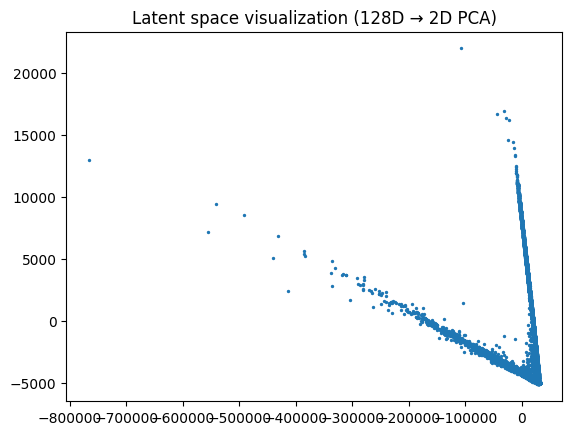

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_all)

plt.scatter(latent_2d[:,0], latent_2d[:,1], s=2)
plt.title("Latent space visualization (128D → 2D PCA)")
plt.show()


In [6]:
# 1. 读取聚类结果（修改路径为你所选的那个）
cluster_df = pd.read_csv("data/Parent_NGSC3_DI_PBMC_analysis/analysis/clustering/kmeans_2_clusters/clusters.csv")

# 2. 查看内容（应该有 Barcode 和 Cluster 两列）
print(cluster_df.head())

# 3. 设置 index 为 barcode（确保与 adata.obs_names 匹配）
cluster_df = cluster_df.set_index("Barcode")

# 4. 添加聚类信息到 adata.obs
adata.obs["kmeans_2"] = adata.obs_names.map(cluster_df["Cluster"])

              Barcode  Cluster
0  AAACCCACATAACTCG-1        2
1  AAACCCACATGTAACC-1        1
2  AAACCCAGTGAGTCAG-1        2
3  AAACCCAGTGCTTATG-1        1
4  AAACGAACAGTCAGTT-1        2


In [7]:
from sklearn.preprocessing import StandardScaler
latent_scaled = StandardScaler().fit_transform(latent_all)

latent_2d = PCA(n_components=2).fit_transform(latent_scaled)

In [8]:
colors = adata.obs["kmeans_2"].values

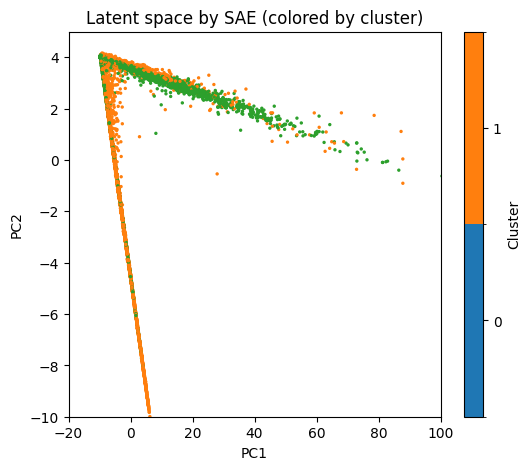

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np

# 设定离散类别数量（假设有 6 类，0~5）
num_classes = len(np.unique(colors))
boundaries = np.arange(-0.5, num_classes + 0.5, 1)
norm = BoundaryNorm(boundaries, ncolors=num_classes)

plt.figure(figsize=(6, 5))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=2, c=colors, cmap='tab10', norm=norm)
plt.xlim(-20, 100)
plt.ylim(-10, 5)
plt.title("Latent space by SAE (colored by cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, ticks=np.arange(num_classes), label="Cluster")
plt.show()
